# Notebook to create the data for cement hydration, elastic moduli and CO2 emissions

In [1]:
# Import relevant packages
import xgems
from util.create_data import add_new_material
from util.create_data import create_sobol_sequence, create_lhs_samples
from util.create_data import complete_hydration_from_data
import pandas as pd
import numpy as np
from prop.elastic_moduli import data_elastic_moduli
from prop.energy import energy_emission_data, CO2_emission
import numpy as np
from scipy.stats import qmc
import pandas as pd
data_path = '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData/'

[2024-05-27 15:10:11.111] [gems3k] [info] Home directory is /afs/psi.ch/user/b/boiger_r
chemicalfun logger not connected
thermofun logger not connected


In [2]:
def normalize_clinker_samples(samples, target_sum, bounds):
    """Normalize the clinker component samples so they sum to the target_sum, with bounds checking."""
    sum_samples = np.sum(samples, axis=1)
    normalized_samples = samples / sum_samples[:, None] * target_sum
    
    # Ensure samples are within their bounds after normalization
    for i in range(samples.shape[1]):  # Iterate over each clinker component
        min_val, max_val = bounds[i]
        # Apply clipping to ensure values remain within bounds
        normalized_samples[:, i] = np.clip(normalized_samples[:, i], min_val, max_val)
        
    return normalized_samples
def sample_with_lhs(bounds_dict, n_samples, clinker_total):
    """Sample using Latin Hypercube Sampling, ensuring clinker components sum to a specified total."""
    sampler = qmc.LatinHypercube(d=len(bounds_dict), seed=42)
    raw_samples = sampler.random(n_samples)

    # Normalize samples to their bounds
    min_vals = np.array([bounds_dict[k][0] for k in bounds_dict])
    max_vals = np.array([bounds_dict[k][1] for k in bounds_dict])
    scaled_samples = raw_samples * (max_vals - min_vals) + min_vals
    
    # Separate the samples into clinker components, 'wc', and additional materials
    clinker_samples = scaled_samples[:, :4]  # First four are clinker components
    wc_samples = scaled_samples[:, 4]       # 'wc' is the fifth variable
    additional_samples = scaled_samples[:, 5:]  # Remaining are additional materials

    # Normalize clinker samples to sum to 96, with bounds checking
    clinker_bounds = [bounds_dict[k] for k in ['C3S', 'C2S', 'C3A', 'C4AF']]
    clinker_samples = normalize_clinker_samples(clinker_samples, clinker_total, clinker_bounds)
    
    # Normalize additional materials so their total does not exceed 100
    additional_samples = normalize_additional_samples(additional_samples)

    # Combine all the samples
    all_samples = np.hstack([clinker_samples, wc_samples[:, None], additional_samples])

    # Define column names
    columns = list(bounds_dict.keys())

    # Create DataFrame
    df = pd.DataFrame(all_samples, columns=columns)
    df['RH'] = 1
    df['T'] = 25
    df['fineness'] = 385
    df['CSH2'] = 4

    return df
def normalize_additional_samples(samples):
    """Normalize additional materials so their total does not exceed 100."""
    sum_samples = np.sum(samples, axis=1)
    mask = sum_samples > 100
    samples[mask] = samples[mask] / sum_samples[mask, None] * 100
    return samples

In [4]:
bounds = {
    'C3S': (45, 80),
    'C2S': (10, 32),
    'C3A': (0, 14),
    'C4AF': (0, 15),
    'wc': (0.3, 0.7),
    'limestone': (0, 20),
    'silica_fume': (0, 10),
    'GGBFS': (0, 35),
    'fly_ash': (0, 35),
    'calcined_clay': (0, 35)
}

# Generate samples, assuming you want 10 samples and clinkers should sum to 96
sampled_df = sample_with_lhs(bounds, 1000, 96)
print(sampled_df)

           C3S        C2S        C3A       C4AF        wc  limestone  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   6.880488   
1    64.773646  17.605959   7.152201   6.468193  0.465823  14.975455   
2    60.857278  21.823251  11.823600   1.495871  0.400889  11.196107   
3    55.248035  27.030514   5.217009   8.504442  0.462212   5.756211   
4    57.710815  16.303625   9.094807  12.890753  0.632467   3.523905   
..         ...        ...        ...        ...       ...        ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   0.230468   
996  54.143969  23.010890  11.745269   7.099872  0.631194  14.839799   
997  64.676746  26.630476   1.413039   3.279739  0.457343  11.577786   
998  61.016788  23.433337   9.582049   1.967826  0.664557  12.180821   
999  70.732394  19.756046   3.441513   2.070047  0.597458  19.031065   

     silica_fume      GGBFS    fly_ash  calcined_clay  RH   T  fineness  CSH2  
0       8.962389  12.187488  26.210516       5.164236  

In [5]:
sampled_df

C3S        C2S        C3A       C4AF        wc  limestone  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   6.880488   
1    64.773646  17.605959   7.152201   6.468193  0.465823  14.975455   
2    60.857278  21.823251  11.823600   1.495871  0.400889  11.196107   
3    55.248035  27.030514   5.217009   8.504442  0.462212   5.756211   
4    57.710815  16.303625   9.094807  12.890753  0.632467   3.523905   
..         ...        ...        ...        ...       ...        ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   0.230468   
996  54.143969  23.010890  11.745269   7.099872  0.631194  14.839799   
997  64.676746  26.630476   1.413039   3.279739  0.457343  11.577786   
998  61.016788  23.433337   9.582049   1.967826  0.664557  12.180821   
999  70.732394  19.756046   3.441513   2.070047  0.597458  19.031065   

     silica_fume      GGBFS    fly_ash  calcined_clay  RH   T  fineness  CSH2  
0       8.962389  12.187488  26.210516       5.164236   1  25       385     4  
1       1.114454  15.817766  29.826033      29.727892   1  25       385     4  
2       8.455333   9.763467  30.339600      25.001093   1  25       385     4  
3       9.118701   0.473350  26.277058      19.156557   1  25       385     4  
4       5.406125  19.694909   2.776113      11.195109   1  25       385     4  
..           ...        ...        ...            ...  ..  ..       ...   ...  
995     4.292554  17.390299  26.094378      12.168256   1  25       385     4  
996     3.966266  20.978287   6.818712      20.631338   1  25       385     4  
997     4.752905  31.085584  21.591315      13.750595   1  25       385     4  
998     2.341680   2.246501  14.653117      31.593280   1  25       385     4  
999     5.146907  19.839213  21.021931      23.923168   1  25       385     4  

[1000 rows x 14 columns]

In [6]:
input = sampled_df
sampled_df['sum1']= sampled_df['C3S']+sampled_df['C2S']+sampled_df['C3A']+sampled_df['C4AF']
sampled_df['sum2']=sampled_df['limestone']+sampled_df['silica_fume']+sampled_df['GGBFS']+sampled_df['fly_ash']+sampled_df['calcined_clay']


sampled_df

C3S        C2S        C3A       C4AF        wc  limestone  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   6.880488   
1    64.773646  17.605959   7.152201   6.468193  0.465823  14.975455   
2    60.857278  21.823251  11.823600   1.495871  0.400889  11.196107   
3    55.248035  27.030514   5.217009   8.504442  0.462212   5.756211   
4    57.710815  16.303625   9.094807  12.890753  0.632467   3.523905   
..         ...        ...        ...        ...       ...        ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   0.230468   
996  54.143969  23.010890  11.745269   7.099872  0.631194  14.839799   
997  64.676746  26.630476   1.413039   3.279739  0.457343  11.577786   
998  61.016788  23.433337   9.582049   1.967826  0.664557  12.180821   
999  70.732394  19.756046   3.441513   2.070047  0.597458  19.031065   

     silica_fume      GGBFS    fly_ash  calcined_clay  RH   T  fineness  CSH2  \
0       8.962389  12.187488  26.210516       5.164236   1  25       385     4   
1       1.114454  15.817766  29.826033      29.727892   1  25       385     4   
2       8.455333   9.763467  30.339600      25.001093   1  25       385     4   
3       9.118701   0.473350  26.277058      19.156557   1  25       385     4   
4       5.406125  19.694909   2.776113      11.195109   1  25       385     4   
..           ...        ...        ...            ...  ..  ..       ...   ...   
995     4.292554  17.390299  26.094378      12.168256   1  25       385     4   
996     3.966266  20.978287   6.818712      20.631338   1  25       385     4   
997     4.752905  31.085584  21.591315      13.750595   1  25       385     4   
998     2.341680   2.246501  14.653117      31.593280   1  25       385     4   
999     5.146907  19.839213  21.021931      23.923168   1  25       385     4   

     sum1       sum2  
0    96.0  59.405116  
1    96.0  91.461600  
2    96.0  84.755600  
3    96.0  60.781876  
4    96.0  42.596160  
..    ...        ...  
995  96.0  60.175955  
996  96.0  67.234401  
997  96.0  82.758185  
998  96.0  63.015399  
999  96.0  88.962283  

[1000 rows x 16 columns]

In [7]:
sampled_df

C3S        C2S        C3A       C4AF        wc  limestone  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   6.880488   
1    64.773646  17.605959   7.152201   6.468193  0.465823  14.975455   
2    60.857278  21.823251  11.823600   1.495871  0.400889  11.196107   
3    55.248035  27.030514   5.217009   8.504442  0.462212   5.756211   
4    57.710815  16.303625   9.094807  12.890753  0.632467   3.523905   
..         ...        ...        ...        ...       ...        ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   0.230468   
996  54.143969  23.010890  11.745269   7.099872  0.631194  14.839799   
997  64.676746  26.630476   1.413039   3.279739  0.457343  11.577786   
998  61.016788  23.433337   9.582049   1.967826  0.664557  12.180821   
999  70.732394  19.756046   3.441513   2.070047  0.597458  19.031065   

     silica_fume      GGBFS    fly_ash  calcined_clay  RH   T  fineness  CSH2  \
0       8.962389  12.187488  26.210516       5.164236   1  25       385     4   
1       1.114454  15.817766  29.826033      29.727892   1  25       385     4   
2       8.455333   9.763467  30.339600      25.001093   1  25       385     4   
3       9.118701   0.473350  26.277058      19.156557   1  25       385     4   
4       5.406125  19.694909   2.776113      11.195109   1  25       385     4   
..           ...        ...        ...            ...  ..  ..       ...   ...   
995     4.292554  17.390299  26.094378      12.168256   1  25       385     4   
996     3.966266  20.978287   6.818712      20.631338   1  25       385     4   
997     4.752905  31.085584  21.591315      13.750595   1  25       385     4   
998     2.341680   2.246501  14.653117      31.593280   1  25       385     4   
999     5.146907  19.839213  21.021931      23.923168   1  25       385     4   

     sum1       sum2  
0    96.0  59.405116  
1    96.0  91.461600  
2    96.0  84.755600  
3    96.0  60.781876  
4    96.0  42.596160  
..    ...        ...  
995  96.0  60.175955  
996  96.0  67.234401  
997  96.0  82.758185  
998  96.0  63.015399  
999  96.0  88.962283  

[1000 rows x 16 columns]

In [8]:
import seaborn as sns

In [9]:
sampled_df.describe()

C3S          C2S          C3A         C4AF           wc  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     61.340666    20.538725     6.781305     7.276291     0.500004   
std       6.559620     5.552514     3.795274     4.117530     0.115533   
min      45.475535    10.000000     0.001371     0.005338     0.300035   
25%      56.862882    16.137216     3.678623     3.902709     0.400156   
50%      61.516362    20.447200     6.872232     7.509099     0.500117   
75%      65.834901    24.901943     9.789343    10.572103     0.599918   
max      80.000000    32.000000    14.000000    15.000000     0.699976   

         limestone  silica_fume        GGBFS      fly_ash  calcined_clay  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean      9.963405     4.982298    17.423177    17.422855      17.426367   
std       5.743958     2.873165    10.018690    10.018371      10.030107   
min       0.008889     0.002541     0.012270     0.015854       0.001038   
25%       5.004866     2.501946     8.760232     8.761564       8.759939   
50%       9.978398     4.999562    17.510517    17.497707      17.464395   
75%      14.963233     7.476047    26.146653    25.948581      26.134490   
max      19.945079     9.990086    34.961315    34.998644      34.985152   

           RH       T  fineness    CSH2         sum1         sum2  
count  1000.0  1000.0    1000.0  1000.0  1000.000000  1000.000000  
mean      1.0    25.0     385.0     4.0    95.936987    67.218102  
std       0.0     0.0       0.0     0.0     0.362839    18.477271  
min       1.0    25.0     385.0     4.0    91.756278    18.424384  
25%       1.0    25.0     385.0     4.0    96.000000    54.834483  
50%       1.0    25.0     385.0     4.0    96.000000    67.135073  
75%       1.0    25.0     385.0     4.0    96.000000    80.768122  
max       1.0    25.0     385.0     4.0    97.295720   100.000000

In [10]:
sampled_df.keys()

Index(['C3S', 'C2S', 'C3A', 'C4AF', 'wc', 'limestone', 'silica_fume', 'GGBFS',
       'fly_ash', 'calcined_clay', 'RH', 'T', 'fineness', 'CSH2', 'sum1',
       'sum2'],
      dtype='object')

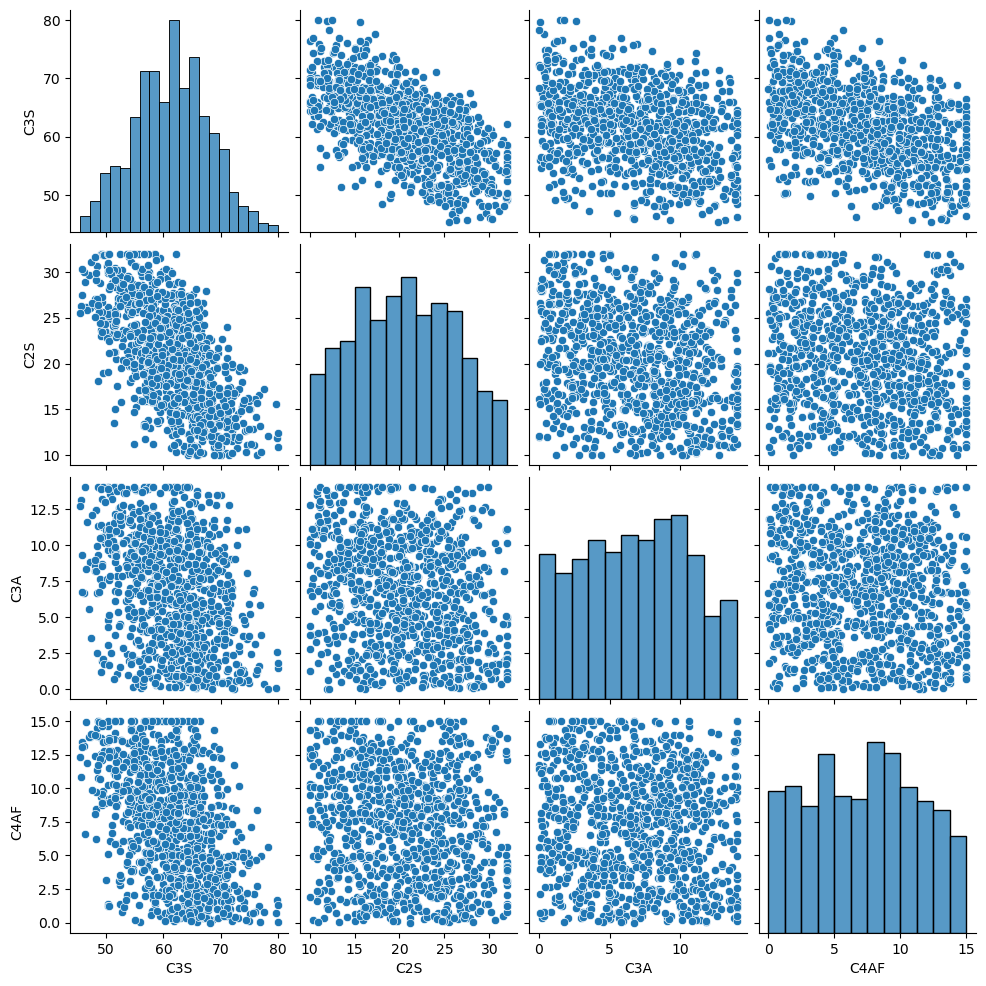

In [11]:
sns.pairplot(sampled_df[['C3S', 'C2S', 'C3A', 'C4AF']])

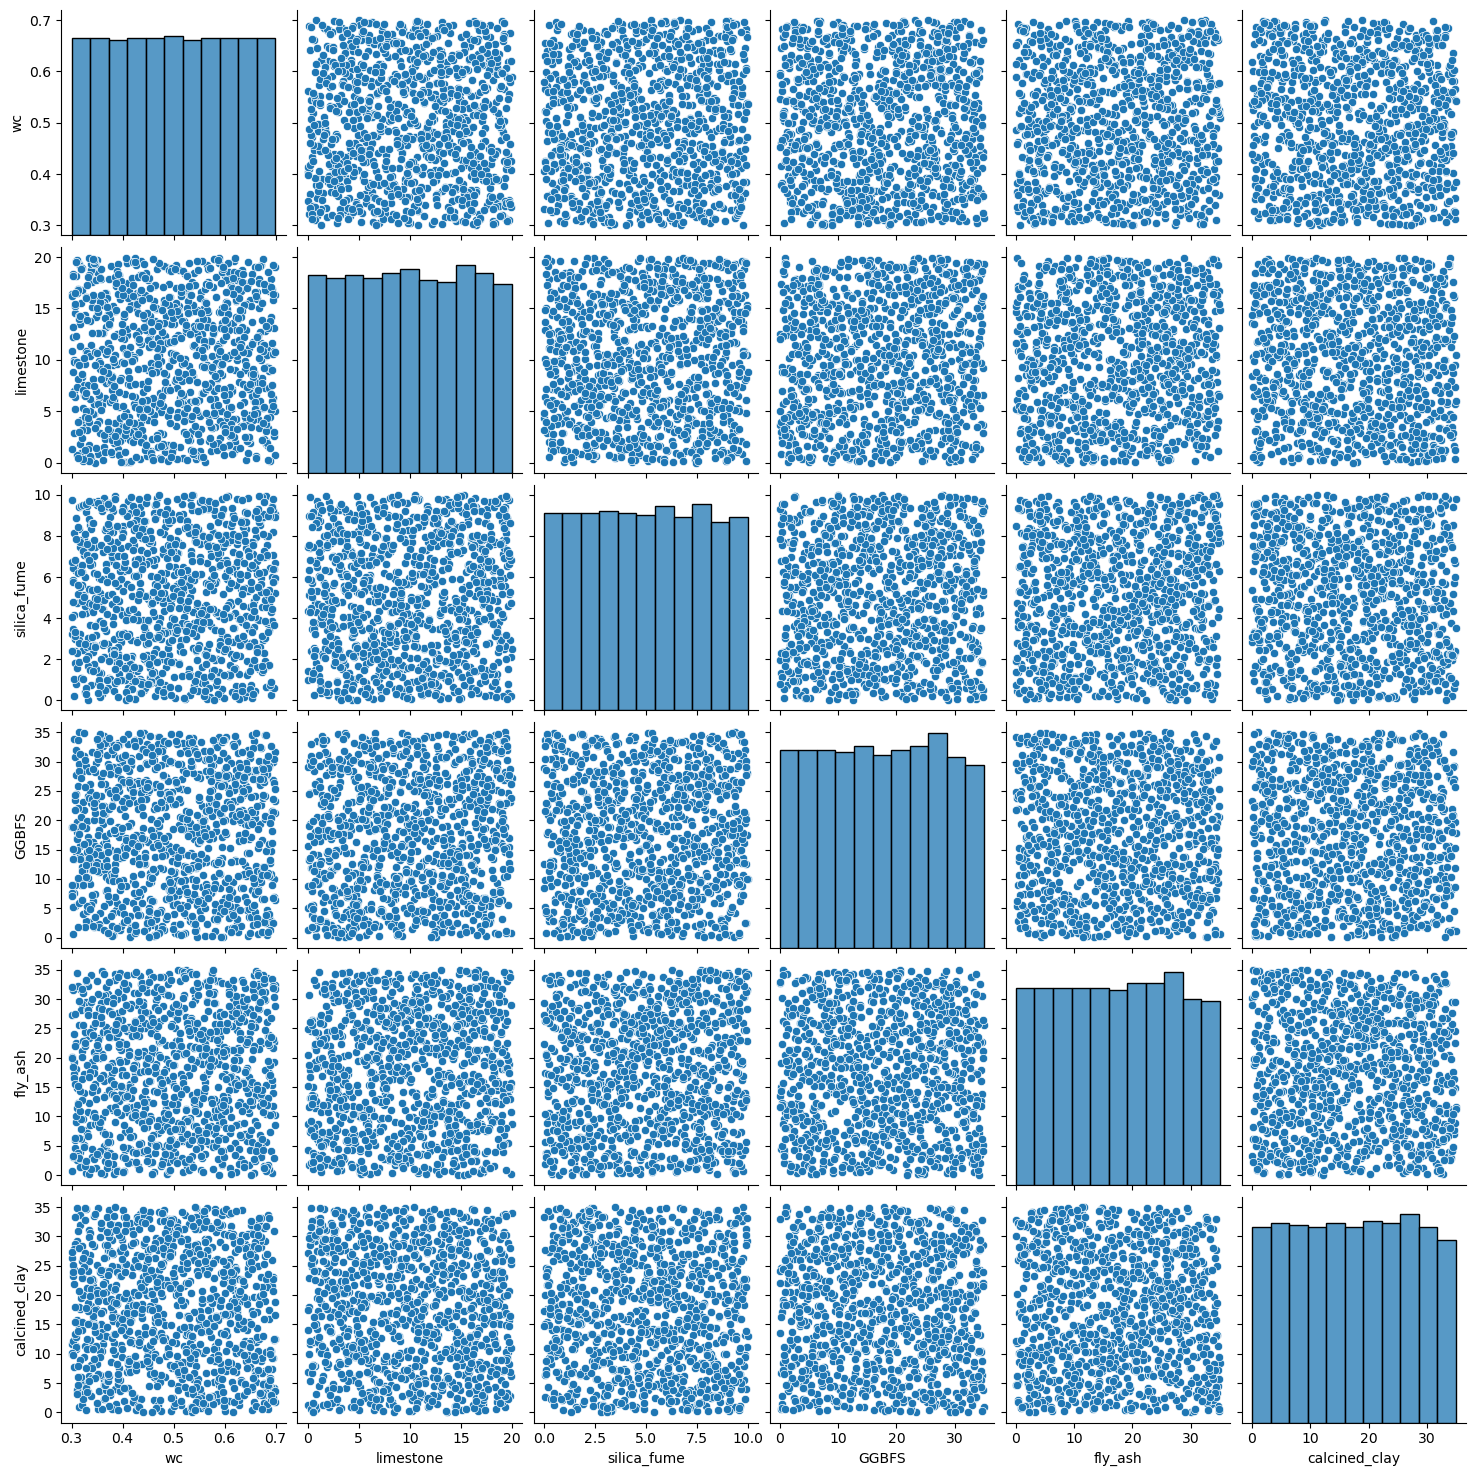

In [12]:
sns.pairplot(sampled_df[['wc', 'limestone', 'silica_fume', 'GGBFS',
       'fly_ash', 'calcined_clay']])

In [13]:

output_materials = ['aq_gen', 'CSHQ', 'Portlandite', 'C3AH6'] #, 'ettringite-AlFe', 'C4AsH12','C4AsH12'(Afm), 'SiO2'(silicate fume), 'ettringite-AlFe' 
output_materials = ["Alite", "Belite", "Aluminate", "Ferrite", "Portlandite", "C3AH6", "C4AsH12", "aq_gen",  "ettringite-AlFe", "hemihydrate", "Anhydrite","arcanite","thenardite","CSHQ", "C3AH6","monosulph-AlFe" ]


In [14]:
input

C3S        C2S        C3A       C4AF        wc  limestone  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   6.880488   
1    64.773646  17.605959   7.152201   6.468193  0.465823  14.975455   
2    60.857278  21.823251  11.823600   1.495871  0.400889  11.196107   
3    55.248035  27.030514   5.217009   8.504442  0.462212   5.756211   
4    57.710815  16.303625   9.094807  12.890753  0.632467   3.523905   
..         ...        ...        ...        ...       ...        ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   0.230468   
996  54.143969  23.010890  11.745269   7.099872  0.631194  14.839799   
997  64.676746  26.630476   1.413039   3.279739  0.457343  11.577786   
998  61.016788  23.433337   9.582049   1.967826  0.664557  12.180821   
999  70.732394  19.756046   3.441513   2.070047  0.597458  19.031065   

     silica_fume      GGBFS    fly_ash  calcined_clay  RH   T  fineness  CSH2  \
0       8.962389  12.187488  26.210516       5.164236   1  25       385     4   
1       1.114454  15.817766  29.826033      29.727892   1  25       385     4   
2       8.455333   9.763467  30.339600      25.001093   1  25       385     4   
3       9.118701   0.473350  26.277058      19.156557   1  25       385     4   
4       5.406125  19.694909   2.776113      11.195109   1  25       385     4   
..           ...        ...        ...            ...  ..  ..       ...   ...   
995     4.292554  17.390299  26.094378      12.168256   1  25       385     4   
996     3.966266  20.978287   6.818712      20.631338   1  25       385     4   
997     4.752905  31.085584  21.591315      13.750595   1  25       385     4   
998     2.341680   2.246501  14.653117      31.593280   1  25       385     4   
999     5.146907  19.839213  21.021931      23.923168   1  25       385     4   

     sum1       sum2  
0    96.0  59.405116  
1    96.0  91.461600  
2    96.0  84.755600  
3    96.0  60.781876  
4    96.0  42.596160  
..    ...        ...  
995  96.0  60.175955  
996  96.0  67.234401  
997  96.0  82.758185  
998  96.0  63.015399  
999  96.0  88.962283  

[1000 rows x 16 columns]

In [15]:
new_order = [
    'C3S', 'C2S', 'C3A', 'C4AF', 'wc', 
    'RH', 'T', 'fineness', 'CSH2', 
    'limestone', 'silica_fume', 'GGBFS',
    'fly_ash', 'calcined_clay'
]

# Reorder the DataFrame columns
input = input[new_order]
input

C3S        C2S        C3A       C4AF        wc  RH   T  fineness  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   1  25       385   
1    64.773646  17.605959   7.152201   6.468193  0.465823   1  25       385   
2    60.857278  21.823251  11.823600   1.495871  0.400889   1  25       385   
3    55.248035  27.030514   5.217009   8.504442  0.462212   1  25       385   
4    57.710815  16.303625   9.094807  12.890753  0.632467   1  25       385   
..         ...        ...        ...        ...       ...  ..  ..       ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   1  25       385   
996  54.143969  23.010890  11.745269   7.099872  0.631194   1  25       385   
997  64.676746  26.630476   1.413039   3.279739  0.457343   1  25       385   
998  61.016788  23.433337   9.582049   1.967826  0.664557   1  25       385   
999  70.732394  19.756046   3.441513   2.070047  0.597458   1  25       385   

     CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0       4   6.880488     8.962389  12.187488  26.210516       5.164236  
1       4  14.975455     1.114454  15.817766  29.826033      29.727892  
2       4  11.196107     8.455333   9.763467  30.339600      25.001093  
3       4   5.756211     9.118701   0.473350  26.277058      19.156557  
4       4   3.523905     5.406125  19.694909   2.776113      11.195109  
..    ...        ...          ...        ...        ...            ...  
995     4   0.230468     4.292554  17.390299  26.094378      12.168256  
996     4  14.839799     3.966266  20.978287   6.818712      20.631338  
997     4  11.577786     4.752905  31.085584  21.591315      13.750595  
998     4  12.180821     2.341680   2.246501  14.653117      31.593280  
999     4  19.031065     5.146907  19.839213  21.021931      23.923168  

[1000 rows x 14 columns]

# Data for Cement hydration

In [16]:
'''# create cement recipes using Sobol sequences

n_sample = 10 #number of sample is 2^n_sample #here 1024
test_n_sample = 6
cook_book = {} #possible parameters for the cement recipe

clinker_phases = {}
clinker_phases["C3S"]=64.6 #alite
clinker_phases["C2S"]=9.3 #belite
clinker_phases["C3A"]=7.4 #tricalcium aluminate
clinker_phases["C4AF"]=7.8 #calcium aluminofernite
clinker_phases['bounds'] = {"C3S":(45,80), "C2S": (10,32), "C3A":(0,14), "C4AF":(0,15)} #bounds from Ullmann's Encyclopedia of Industrial Chemistry

#add clinkers to the cook book
cook_book['clink_phase'] = clinker_phases

# add materials and properties to the cook book
add_new_material(cook_book, 'RH', 1)# relative humidity
add_new_material(cook_book, 'T', 25)# temperature
add_new_material(cook_book,'fineness', 385)
add_new_material(cook_book,'wc', 0.5, (0.3,0.7))# bounds given by Dr. Dmitrii Kulik from PSI
add_new_material(cook_book,'CSH2', 4, (4.0,4.0))# OPC has 2-3% gypsum
add_new_material(cook_book,'limestone', 1.0, (0,20))#https://ecra-online.org/newsletters/high-limestone-content-in-cement-an-important-step-towards-decarbonisation/#:~:text=The%20content%20of%20limestone%20has,the%20clinker%20content%20of%20cement.
add_new_material(cook_book,'silica_fume', 1.0, (0,10))# https://microsilica-fume.com/much-silica-fume-add-concrete.html#:~:text=the%20content%20of%20micro%20silica,to%2010%25%20of%20cementitious%20material. #https://www.researchgate.net/publication/327671198_Effect_of_Replacement_of_Cement_by_Different_Percentages_of_Silica_Fume
add_new_material(cook_book,'GGBFS', 1.0, (0,35)) # between 20 and 80% for concrete https://link.springer.com/chapter/10.1007/978-3-319-70606-1_1
add_new_material(cook_book,'fly_ash', 1.0, (0,35)) # between 15 to 30 % https://www.fhwa.dot.gov/pavement/recycling/fach03.cfm#:~:text=Typically%2C%2015%20percent%20to%2030,%3A1%20to%201.5%3A1.
add_new_material(cook_book,'calcined_clay', 1.0, (0,35)) # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7660299/

# if one wants to add unknown materials to the cook_book, please enter the recipe in the SCM dictionnary in final_hydration.py 

#create recipe from the cook book
#train_input = pd.DataFrame(create_sobol_sequence(cook_book, n_sample))


normalized_samples = create_lhs_samples(cook_book, 11)
#train_input = pd.DataFrame(create_lhs_samples(cook_book, 1000))
#set the output materials of hydration
# this one is very limited, could be extended in future work to have all the details for elastic moduli

bounds = {
    'C3S': (45, 80),
    'C2S': (10, 32),
    'C3A': (0, 14),
    'C4AF': (0, 15),
    'wc': (0.3, 0.7)
}
'''


'# create cement recipes using Sobol sequences\n\nn_sample = 10 #number of sample is 2^n_sample #here 1024\ntest_n_sample = 6\ncook_book = {} #possible parameters for the cement recipe\n\nclinker_phases = {}\nclinker_phases["C3S"]=64.6 #alite\nclinker_phases["C2S"]=9.3 #belite\nclinker_phases["C3A"]=7.4 #tricalcium aluminate\nclinker_phases["C4AF"]=7.8 #calcium aluminofernite\nclinker_phases[\'bounds\'] = {"C3S":(45,80), "C2S": (10,32), "C3A":(0,14), "C4AF":(0,15)} #bounds from Ullmann\'s Encyclopedia of Industrial Chemistry\n\n#add clinkers to the cook book\ncook_book[\'clink_phase\'] = clinker_phases\n\n# add materials and properties to the cook book\nadd_new_material(cook_book, \'RH\', 1)# relative humidity\nadd_new_material(cook_book, \'T\', 25)# temperature\nadd_new_material(cook_book,\'fineness\', 385)\nadd_new_material(cook_book,\'wc\', 0.5, (0.3,0.7))# bounds given by Dr. Dmitrii Kulik from PSI\nadd_new_material(cook_book,\'CSH2\', 4, (4.0,4.0))# OPC has 2-3% gypsum\nadd_new_ma

In [17]:
# Hydration using GEMS
to_drop, train_output,pd_vol_frac = complete_hydration_from_data(input, output_materials, False)


In [18]:
pd_vol_frac

{'0': aq_gen             4.222192e-01
 gas_gen            3.492125e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               3.068892e-01
                        ...     
 Quartz             0.000000e+00
 Silica-amorph      0.000000e+00
 Strontianite       0.000000e+00
 Celestite          0.000000e+00
 Rutile             0.000000e+00
 Length: 110, dtype: float64,
 '1': aq_gen             3.661219e-01
 gas_gen            3.436806e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               1.447659e-01
                        ...     
 Quartz             0.000000e+00
 Silica-amorph      0.000000e+00
 Strontianite       0.000000e+00
 Celestite          0.000000e+00
 Rutile             0.000000e+00
 Length: 110, dtype: float64,
 '2': aq_gen             3.263062e-01
 gas_gen            3.947666e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               1.648042e-01
                        ...     
 

In [19]:
train_input_test = input.copy()


In [20]:
pd_vol_frac

{'0': aq_gen             4.222192e-01
 gas_gen            3.492125e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               3.068892e-01
                        ...     
 Quartz             0.000000e+00
 Silica-amorph      0.000000e+00
 Strontianite       0.000000e+00
 Celestite          0.000000e+00
 Rutile             0.000000e+00
 Length: 110, dtype: float64,
 '1': aq_gen             3.661219e-01
 gas_gen            3.436806e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               1.447659e-01
                        ...     
 Quartz             0.000000e+00
 Silica-amorph      0.000000e+00
 Strontianite       0.000000e+00
 Celestite          0.000000e+00
 Rutile             0.000000e+00
 Length: 110, dtype: float64,
 '2': aq_gen             3.263062e-01
 gas_gen            3.947666e-13
 HCA-Friedels-ss    0.000000e+00
 C3(AF)S0_84H       0.000000e+00
 CSHQ               1.648042e-01
                        ...     
 

In [21]:
pd_vol_frac['0'].sort_values(ascending=False).head(20)

aq_gen             4.222192e-01
CSHQ               3.068892e-01
C3AH6              9.778680e-02
Portlandite        8.835438e-02
OH-hydrotalcite    6.108319e-02
Iron               1.039380e-02
Titanite           5.137703e-03
HAP                4.466134e-03
Troilite           3.669577e-03
gas_gen            3.492125e-13
arcanite           0.000000e+00
Melanterite        0.000000e+00
Pyrite             0.000000e+00
Goethite           0.000000e+00
Ferrihydrite-am    0.000000e+00
syngenite          0.000000e+00
Magnetite          0.000000e+00
Hematite           0.000000e+00
Siderite           0.000000e+00
thaumasite         0.000000e+00
dtype: float64

In [22]:
pd_df = pd.DataFrame(pd_vol_frac)
list_pd = pd_df.sum(axis = 1)
list_pd

aq_gen             3.526555e+02
gas_gen            3.797623e-10
HCA-Friedels-ss    1.175718e-06
C3(AF)S0_84H       0.000000e+00
CSHQ               1.912291e+02
                       ...     
Quartz             0.000000e+00
Silica-amorph      0.000000e+00
Strontianite       0.000000e+00
Celestite          0.000000e+00
Rutile             0.000000e+00
Length: 110, dtype: float64

In [23]:
pd_df1 = pd_df.copy().T
pd_df1

aq_gen       gas_gen  HCA-Friedels-ss  C3(AF)S0_84H      CSHQ  \
0    0.422219  3.492125e-13              0.0           0.0  0.306889   
1    0.366122  3.436806e-13              0.0           0.0  0.144766   
2    0.326306  3.947666e-13              0.0           0.0  0.164804   
3    0.349835  4.463835e-13              0.0           0.0  0.323567   
4    0.379584  3.996415e-13              0.0           0.0  0.266418   
..        ...           ...              ...           ...       ...   
995  0.352678  4.092073e-13              0.0           0.0  0.157423   
996  0.426557  3.428993e-13              0.0           0.0  0.231430   
997  0.436080  3.552561e-13              0.0           0.0  0.000000   
998  0.516478  3.416435e-13              0.0           0.0  0.210143   
999  0.426645  3.121271e-13              0.0           0.0  0.251769   

     ettringite-AlFe  monosulph-AlFe  straetlingite  SO4_OH_AFm  SO4_CO3_AFt  \
0                0.0             0.0            0.0         0.0          0.0   
1                0.0             0.0            0.0         0.0          0.0   
2                0.0             0.0            0.0         0.0          0.0   
3                0.0             0.0            0.0         0.0          0.0   
4                0.0             0.0            0.0         0.0          0.0   
..               ...             ...            ...         ...          ...   
995              0.0             0.0            0.0         0.0          0.0   
996              0.0             0.0            0.0         0.0          0.0   
997              0.0             0.0            0.0         0.0          0.0   
998              0.0             0.0            0.0         0.0          0.0   
999              0.0             0.0            0.0         0.0          0.0   

     ...  Natrolite  ZeoliteX  ZeoliteY  Na-oxide  Sulphur  Quartz  \
0    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
1    ...   0.067847       0.0       0.0       0.0      0.0     0.0   
2    ...   0.071720       0.0       0.0       0.0      0.0     0.0   
3    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
4    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
..   ...        ...       ...       ...       ...      ...     ...   
995  ...   0.025911       0.0       0.0       0.0      0.0     0.0   
996  ...   0.000000       0.0       0.0       0.0      0.0     0.0   
997  ...   0.045252       0.0       0.0       0.0      0.0     0.0   
998  ...   0.000000       0.0       0.0       0.0      0.0     0.0   
999  ...   0.000000       0.0       0.0       0.0      0.0     0.0   

     Silica-amorph  Strontianite  Celestite  Rutile  
0              0.0           0.0        0.0     0.0  
1              0.0           0.0        0.0     0.0  
2              0.0           0.0        0.0     0.0  
3              0.0           0.0        0.0     0.0  
4              0.0           0.0        0.0     0.0  
..             ...           ...        ...     ...  
995            0.0           0.0        0.0     0.0  
996            0.0           0.0        0.0     0.0  
997            0.0           0.0        0.0     0.0  
998            0.0           0.0        0.0     0.0  
999            0.0           0.0        0.0     0.0  

[944 rows x 110 columns]

In [24]:
input

C3S        C2S        C3A       C4AF        wc  RH   T  fineness  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   1  25       385   
1    64.773646  17.605959   7.152201   6.468193  0.465823   1  25       385   
2    60.857278  21.823251  11.823600   1.495871  0.400889   1  25       385   
3    55.248035  27.030514   5.217009   8.504442  0.462212   1  25       385   
4    57.710815  16.303625   9.094807  12.890753  0.632467   1  25       385   
..         ...        ...        ...        ...       ...  ..  ..       ...   
995  71.058060  16.755838   4.603968   3.582134  0.460128   1  25       385   
996  54.143969  23.010890  11.745269   7.099872  0.631194   1  25       385   
997  64.676746  26.630476   1.413039   3.279739  0.457343   1  25       385   
998  61.016788  23.433337   9.582049   1.967826  0.664557   1  25       385   
999  70.732394  19.756046   3.441513   2.070047  0.597458   1  25       385   

     CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0       4   6.880488     8.962389  12.187488  26.210516       5.164236  
1       4  14.975455     1.114454  15.817766  29.826033      29.727892  
2       4  11.196107     8.455333   9.763467  30.339600      25.001093  
3       4   5.756211     9.118701   0.473350  26.277058      19.156557  
4       4   3.523905     5.406125  19.694909   2.776113      11.195109  
..    ...        ...          ...        ...        ...            ...  
995     4   0.230468     4.292554  17.390299  26.094378      12.168256  
996     4  14.839799     3.966266  20.978287   6.818712      20.631338  
997     4  11.577786     4.752905  31.085584  21.591315      13.750595  
998     4  12.180821     2.341680   2.246501  14.653117      31.593280  
999     4  19.031065     5.146907  19.839213  21.021931      23.923168  

[1000 rows x 14 columns]

In [25]:
pd_df1

aq_gen       gas_gen  HCA-Friedels-ss  C3(AF)S0_84H      CSHQ  \
0    0.422219  3.492125e-13              0.0           0.0  0.306889   
1    0.366122  3.436806e-13              0.0           0.0  0.144766   
2    0.326306  3.947666e-13              0.0           0.0  0.164804   
3    0.349835  4.463835e-13              0.0           0.0  0.323567   
4    0.379584  3.996415e-13              0.0           0.0  0.266418   
..        ...           ...              ...           ...       ...   
995  0.352678  4.092073e-13              0.0           0.0  0.157423   
996  0.426557  3.428993e-13              0.0           0.0  0.231430   
997  0.436080  3.552561e-13              0.0           0.0  0.000000   
998  0.516478  3.416435e-13              0.0           0.0  0.210143   
999  0.426645  3.121271e-13              0.0           0.0  0.251769   

     ettringite-AlFe  monosulph-AlFe  straetlingite  SO4_OH_AFm  SO4_CO3_AFt  \
0                0.0             0.0            0.0         0.0          0.0   
1                0.0             0.0            0.0         0.0          0.0   
2                0.0             0.0            0.0         0.0          0.0   
3                0.0             0.0            0.0         0.0          0.0   
4                0.0             0.0            0.0         0.0          0.0   
..               ...             ...            ...         ...          ...   
995              0.0             0.0            0.0         0.0          0.0   
996              0.0             0.0            0.0         0.0          0.0   
997              0.0             0.0            0.0         0.0          0.0   
998              0.0             0.0            0.0         0.0          0.0   
999              0.0             0.0            0.0         0.0          0.0   

     ...  Natrolite  ZeoliteX  ZeoliteY  Na-oxide  Sulphur  Quartz  \
0    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
1    ...   0.067847       0.0       0.0       0.0      0.0     0.0   
2    ...   0.071720       0.0       0.0       0.0      0.0     0.0   
3    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
4    ...   0.000000       0.0       0.0       0.0      0.0     0.0   
..   ...        ...       ...       ...       ...      ...     ...   
995  ...   0.025911       0.0       0.0       0.0      0.0     0.0   
996  ...   0.000000       0.0       0.0       0.0      0.0     0.0   
997  ...   0.045252       0.0       0.0       0.0      0.0     0.0   
998  ...   0.000000       0.0       0.0       0.0      0.0     0.0   
999  ...   0.000000       0.0       0.0       0.0      0.0     0.0   

     Silica-amorph  Strontianite  Celestite  Rutile  
0              0.0           0.0        0.0     0.0  
1              0.0           0.0        0.0     0.0  
2              0.0           0.0        0.0     0.0  
3              0.0           0.0        0.0     0.0  
4              0.0           0.0        0.0     0.0  
..             ...           ...        ...     ...  
995            0.0           0.0        0.0     0.0  
996            0.0           0.0        0.0     0.0  
997            0.0           0.0        0.0     0.0  
998            0.0           0.0        0.0     0.0  
999            0.0           0.0        0.0     0.0  

[944 rows x 110 columns]

In [26]:
output_keys = list_pd[list_pd >0].keys()

In [27]:
train_output2 = pd_df1[output_keys]
train_output2

aq_gen       gas_gen  HCA-Friedels-ss      CSHQ  straetlingite  \
0    0.422219  3.492125e-13              0.0  0.306889            0.0   
1    0.366122  3.436806e-13              0.0  0.144766            0.0   
2    0.326306  3.947666e-13              0.0  0.164804            0.0   
3    0.349835  4.463835e-13              0.0  0.323567            0.0   
4    0.379584  3.996415e-13              0.0  0.266418            0.0   
..        ...           ...              ...       ...            ...   
995  0.352678  4.092073e-13              0.0  0.157423            0.0   
996  0.426557  3.428993e-13              0.0  0.231430            0.0   
997  0.436080  3.552561e-13              0.0  0.000000            0.0   
998  0.516478  3.416435e-13              0.0  0.210143            0.0   
999  0.426645  3.121271e-13              0.0  0.251769            0.0   

     Gibbsite    Belite     C3AH6  C4Ac0_5H12  Portlandite       HAP  \
0         0.0  0.000000  0.097787         0.0     0.088354  0.004466   
1         0.0  0.000000  0.057969         0.0     0.207437  0.025676   
2         0.0  0.011435  0.045745         0.0     0.236557  0.024834   
3         0.0  0.000000  0.051399         0.0     0.175740  0.021216   
4         0.0  0.000000  0.183942         0.0     0.057216  0.011121   
..        ...       ...       ...         ...          ...       ...   
995       0.0  0.089615  0.108790         0.0     0.126086  0.012524   
996       0.0  0.000000  0.162018         0.0     0.054659  0.017603   
997       0.0  0.159141  0.126889         0.0     0.065790  0.012308   
998       0.0  0.000000  0.050424         0.0     0.128303  0.026676   
999       0.0  0.000000  0.104469         0.0     0.086017  0.018620   

     Titanite      Iron  Magnetite  Goethite  Troilite  OH-hydrotalcite  \
0    0.005138  0.010394        0.0       0.0  0.003670         0.061083   
1    0.029537  0.017511        0.0       0.0  0.007224         0.075911   
2    0.028568  0.017944        0.0       0.0  0.007514         0.064572   
3    0.024407  0.018228        0.0       0.0  0.007345         0.028264   
4    0.012793  0.005761        0.0       0.0  0.005237         0.077929   
..        ...       ...        ...       ...       ...              ...   
995  0.014407  0.013788        0.0       0.0  0.005544         0.093235   
996  0.020250  0.007352        0.0       0.0  0.005866         0.074266   
997  0.014159  0.010713        0.0       0.0  0.004947         0.124721   
998  0.030687  0.011424        0.0       0.0  0.007394         0.018471   
999  0.021420  0.010978        0.0       0.0  0.005781         0.074299   

     Brucite  Pyrochroite  Natrolite  
0        0.0          0.0   0.000000  
1        0.0          0.0   0.067847  
2        0.0          0.0   0.071720  
3        0.0          0.0   0.000000  
4        0.0          0.0   0.000000  
..       ...          ...        ...  
995      0.0          0.0   0.025911  
996      0.0          0.0   0.000000  
997      0.0          0.0   0.045252  
998      0.0          0.0   0.000000  
999      0.0          0.0   0.000000  

[944 rows x 20 columns]

In [28]:
train_output2 = train_output2.reset_index(drop= True)
train_output2

aq_gen       gas_gen  HCA-Friedels-ss      CSHQ  straetlingite  \
0    0.422219  3.492125e-13              0.0  0.306889            0.0   
1    0.366122  3.436806e-13              0.0  0.144766            0.0   
2    0.326306  3.947666e-13              0.0  0.164804            0.0   
3    0.349835  4.463835e-13              0.0  0.323567            0.0   
4    0.379584  3.996415e-13              0.0  0.266418            0.0   
..        ...           ...              ...       ...            ...   
939  0.352678  4.092073e-13              0.0  0.157423            0.0   
940  0.426557  3.428993e-13              0.0  0.231430            0.0   
941  0.436080  3.552561e-13              0.0  0.000000            0.0   
942  0.516478  3.416435e-13              0.0  0.210143            0.0   
943  0.426645  3.121271e-13              0.0  0.251769            0.0   

     Gibbsite    Belite     C3AH6  C4Ac0_5H12  Portlandite       HAP  \
0         0.0  0.000000  0.097787         0.0     0.088354  0.004466   
1         0.0  0.000000  0.057969         0.0     0.207437  0.025676   
2         0.0  0.011435  0.045745         0.0     0.236557  0.024834   
3         0.0  0.000000  0.051399         0.0     0.175740  0.021216   
4         0.0  0.000000  0.183942         0.0     0.057216  0.011121   
..        ...       ...       ...         ...          ...       ...   
939       0.0  0.089615  0.108790         0.0     0.126086  0.012524   
940       0.0  0.000000  0.162018         0.0     0.054659  0.017603   
941       0.0  0.159141  0.126889         0.0     0.065790  0.012308   
942       0.0  0.000000  0.050424         0.0     0.128303  0.026676   
943       0.0  0.000000  0.104469         0.0     0.086017  0.018620   

     Titanite      Iron  Magnetite  Goethite  Troilite  OH-hydrotalcite  \
0    0.005138  0.010394        0.0       0.0  0.003670         0.061083   
1    0.029537  0.017511        0.0       0.0  0.007224         0.075911   
2    0.028568  0.017944        0.0       0.0  0.007514         0.064572   
3    0.024407  0.018228        0.0       0.0  0.007345         0.028264   
4    0.012793  0.005761        0.0       0.0  0.005237         0.077929   
..        ...       ...        ...       ...       ...              ...   
939  0.014407  0.013788        0.0       0.0  0.005544         0.093235   
940  0.020250  0.007352        0.0       0.0  0.005866         0.074266   
941  0.014159  0.010713        0.0       0.0  0.004947         0.124721   
942  0.030687  0.011424        0.0       0.0  0.007394         0.018471   
943  0.021420  0.010978        0.0       0.0  0.005781         0.074299   

     Brucite  Pyrochroite  Natrolite  
0        0.0          0.0   0.000000  
1        0.0          0.0   0.067847  
2        0.0          0.0   0.071720  
3        0.0          0.0   0.000000  
4        0.0          0.0   0.000000  
..       ...          ...        ...  
939      0.0          0.0   0.025911  
940      0.0          0.0   0.000000  
941      0.0          0.0   0.045252  
942      0.0          0.0   0.000000  
943      0.0          0.0   0.000000  

[944 rows x 20 columns]

In [29]:
train_output2.sum()

aq_gen             3.526555e+02
gas_gen            3.797623e-10
HCA-Friedels-ss    1.175718e-06
CSHQ               1.912291e+02
straetlingite      1.989446e-01
Gibbsite           1.059060e-02
Belite             3.810972e+01
C3AH6              1.062762e+02
C4Ac0_5H12         5.213642e-05
Portlandite        1.139746e+02
HAP                1.561821e+01
Titanite           1.796670e+01
Iron               1.103446e+01
Magnetite          1.371446e-02
Goethite           6.520239e-03
Troilite           5.659048e+00
OH-hydrotalcite    7.218819e+01
Brucite            2.690386e-01
Pyrochroite        4.590890e-12
Natrolite          1.878943e+01
dtype: float64

In [30]:
name = '_LHS_1000_fin_'
#save failed recipe
input.iloc[to_drop].to_csv(data_path+'/failed_recipe'+name+'.csv')

#save successful recipes and hydration product
train_input = input.drop(to_drop, axis =0)
train_input = train_input.reset_index(drop=True)
train_input.to_csv(data_path+'/recipe_data'+name+'.csv')
train_output2.to_csv(data_path+'/final_hydration'+name+'.csv')


# Data for Elastic Moduli of Cement Paste

In [31]:
# Import data
name = '_LHS_10000_'
file_hydr = data_path +'/final_hydration'+name+'.csv'
data_hydr = pd.read_csv(file_hydr, index_col=[0])

file_recipe = data_path + '/recipe_data'+name+'.csv'
data_recipe = pd.read_csv(file_recipe, index_col = [0])
data_recipe = data_recipe.reset_index(drop=True)
#data_hydr = data_hydr.reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk1/projects/Cement/02-Software_and_Models/Models/InputData//final_hydration_LHS_10000_.csv'

In [16]:
#data_hydr = data_hydr.transpose()
#data_hydr

In [17]:
data_hydr

aq_gen       gas_gen  HCA-Friedels-ss      CSHQ  straetlingite  \
0     0.384401  3.573669e-13              0.0  0.114332            0.0   
1     0.343840  3.638728e-13              0.0  0.193853            0.0   
2     0.431903  4.176996e-13              0.0  0.227122            0.0   
3     0.388702  3.098643e-13              0.0  0.256602            0.0   
4     0.258245  5.516043e-13              0.0  0.052604            0.0   
...        ...           ...              ...       ...            ...   
9444  0.433335  3.269800e-13              0.0  0.307479            0.0   
9445  0.405759  4.018803e-13              0.0  0.049353            0.0   
9446  0.394793  2.895759e-13              0.0  0.236304            0.0   
9447  0.470212  3.523275e-13              0.0  0.283643            0.0   
9448  0.302940  4.393055e-13              0.0  0.244998            0.0   

      SO4_OH_AFm  Gibbsite    Belite     C3AH6  C4Ac0_5H12  ...  Titanite  \
0            0.0       0.0  0.077937  0.119594         0.0  ...  0.018225   
1            0.0       0.0  0.000000  0.086410         0.0  ...  0.024300   
2            0.0       0.0  0.000000  0.099516         0.0  ...  0.034396   
3            0.0       0.0  0.000000  0.165884         0.0  ...  0.012181   
4            0.0       0.0  0.000000  0.012070         0.0  ...  0.051066   
...          ...       ...       ...       ...         ...  ...       ...   
9444         0.0       0.0  0.000000  0.074893         0.0  ...  0.005470   
9445         0.0       0.0  0.200094  0.189970         0.0  ...  0.000325   
9446         0.0       0.0  0.000000  0.158278         0.0  ...  0.014730   
9447         0.0       0.0  0.000000  0.061544         0.0  ...  0.010676   
9448         0.0       0.0  0.077882  0.165820         0.0  ...  0.000036   

          Iron  Magnetite  Goethite  Pyrite  Troilite  OH-hydrotalcite  \
0     0.013187        0.0       0.0     0.0  0.005663         0.108712   
1     0.017485        0.0       0.0     0.0  0.006633         0.082092   
2     0.009717        0.0       0.0     0.0  0.008582         0.029083   
3     0.011497        0.0       0.0     0.0  0.004398         0.103551   
4     0.012988        0.0       0.0     0.0  0.012169         0.031221   
...        ...        ...       ...     ...       ...              ...   
9444  0.009955        0.0       0.0     0.0  0.003535         0.065369   
9445  0.013460        0.0       0.0     0.0  0.003370         0.126970   
9446  0.010679        0.0       0.0     0.0  0.004598         0.111133   
9447  0.012897        0.0       0.0     0.0  0.004509         0.035568   
9448  0.017022        0.0       0.0     0.0  0.003688         0.099100   

      Brucite  Pyrochroite  Natrolite  
0         0.0          0.0   0.044039  
1         0.0          0.0   0.048828  
2         0.0          0.0   0.000000  
3         0.0          0.0   0.000000  
4         0.0          0.0   0.152717  
...       ...          ...        ...  
9444      0.0          0.0   0.000000  
9445      0.0          0.0   0.000000  
9446      0.0          0.0   0.008914  
9447      0.0          0.0   0.000000  
9448      0.0          0.0   0.000000  

[9449 rows x 22 columns]

In [18]:
data_hydr.sum().sort_values()

Pyrochroite        3.776729e-11
gas_gen            3.799340e-09
C4Ac0_5H12         2.844350e-06
Pyrite             2.195841e-03
SO4_OH_AFm         3.898957e-02
Goethite           5.492037e-02
Magnetite          1.073063e-01
Gibbsite           1.889517e-01
HCA-Friedels-ss    2.197762e-01
straetlingite      1.138438e+00
Brucite            4.516748e+00
Troilite           5.649225e+01
Iron               1.107053e+02
HAP                1.560914e+02
Titanite           1.795628e+02
Natrolite          1.811465e+02
Belite             3.702744e+02
OH-hydrotalcite    7.183987e+02
C3AH6              1.069130e+03
Portlandite        1.135232e+03
CSHQ               1.940084e+03
aq_gen             3.525616e+03
dtype: float64

In [21]:
data_hydr['other_material']= data_hydr['Pyrochroite']+data_hydr['gas_gen']+data_hydr['HCA-Friedels-ss']+data_hydr['C4Ac0_5H12']+data_hydr['Goethite']+data_hydr['Gibbsite']+data_hydr['Magnetite']+data_hydr['straetlingite']+data_hydr['Brucite']+data_hydr['Troilite']+data_hydr['Iron']+ data_hydr['HAP']+data_hydr['Titanite']+data_hydr['Natrolite']


print(data_hydr.sum().sort_values())
data_hydr



Pyrochroite        3.776729e-11
gas_gen            3.799340e-09
C4Ac0_5H12         2.844350e-06
Pyrite             2.195841e-03
SO4_OH_AFm         3.898957e-02
Goethite           5.492037e-02
Magnetite          1.073063e-01
Gibbsite           1.889517e-01
HCA-Friedels-ss    2.197762e-01
straetlingite      1.138438e+00
Brucite            4.516748e+00
Troilite           5.649225e+01
Iron               1.107053e+02
HAP                1.560914e+02
Titanite           1.795628e+02
Natrolite          1.811465e+02
Belite             3.702744e+02
other_material     6.902243e+02
OH-hydrotalcite    7.183987e+02
C3AH6              1.069130e+03
Portlandite        1.135232e+03
CSHQ               1.940084e+03
aq_gen             3.525616e+03
dtype: float64


aq_gen       gas_gen  HCA-Friedels-ss      CSHQ  straetlingite  \
0     0.384401  3.573669e-13              0.0  0.114332            0.0   
1     0.343840  3.638728e-13              0.0  0.193853            0.0   
2     0.431903  4.176996e-13              0.0  0.227122            0.0   
3     0.388702  3.098643e-13              0.0  0.256602            0.0   
4     0.258245  5.516043e-13              0.0  0.052604            0.0   
...        ...           ...              ...       ...            ...   
9444  0.433335  3.269800e-13              0.0  0.307479            0.0   
9445  0.405759  4.018803e-13              0.0  0.049353            0.0   
9446  0.394793  2.895759e-13              0.0  0.236304            0.0   
9447  0.470212  3.523275e-13              0.0  0.283643            0.0   
9448  0.302940  4.393055e-13              0.0  0.244998            0.0   

      SO4_OH_AFm  Gibbsite    Belite     C3AH6  C4Ac0_5H12  ...      Iron  \
0            0.0       0.0  0.077937  0.119594         0.0  ...  0.013187   
1            0.0       0.0  0.000000  0.086410         0.0  ...  0.017485   
2            0.0       0.0  0.000000  0.099516         0.0  ...  0.009717   
3            0.0       0.0  0.000000  0.165884         0.0  ...  0.011497   
4            0.0       0.0  0.000000  0.012070         0.0  ...  0.012988   
...          ...       ...       ...       ...         ...  ...       ...   
9444         0.0       0.0  0.000000  0.074893         0.0  ...  0.009955   
9445         0.0       0.0  0.200094  0.189970         0.0  ...  0.013460   
9446         0.0       0.0  0.000000  0.158278         0.0  ...  0.010679   
9447         0.0       0.0  0.000000  0.061544         0.0  ...  0.012897   
9448         0.0       0.0  0.077882  0.165820         0.0  ...  0.017022   

      Magnetite  Goethite  Pyrite  Troilite  OH-hydrotalcite  Brucite  \
0           0.0       0.0     0.0  0.005663         0.108712      0.0   
1           0.0       0.0     0.0  0.006633         0.082092      0.0   
2           0.0       0.0     0.0  0.008582         0.029083      0.0   
3           0.0       0.0     0.0  0.004398         0.103551      0.0   
4           0.0       0.0     0.0  0.012169         0.031221      0.0   
...         ...       ...     ...       ...              ...      ...   
9444        0.0       0.0     0.0  0.003535         0.065369      0.0   
9445        0.0       0.0     0.0  0.003370         0.126970      0.0   
9446        0.0       0.0     0.0  0.004598         0.111133      0.0   
9447        0.0       0.0     0.0  0.004509         0.035568      0.0   
9448        0.0       0.0     0.0  0.003688         0.099100      0.0   

      Pyrochroite  Natrolite  other_material  
0             0.0   0.044039        0.096957  
1             0.0   0.048828        0.118369  
2             0.0   0.000000        0.082595  
3             0.0   0.000000        0.038664  
4             0.0   0.152717        0.273331  
...           ...        ...             ...  
9444          0.0   0.000000        0.023714  
9445          0.0   0.000000        0.017438  
9446          0.0   0.008914        0.051725  
9447          0.0   0.000000        0.037363  
9448          0.0   0.000000        0.020777  

[9449 rows x 23 columns]

In [62]:
data_hydr = data_hydr.drop(['Pyrochroite','gas_gen','HCA-Friedels-ss','C4Ac0_5H12','Goethite','Gibbsite','Magnetite','straetlingite','Brucite'], axis =1)             #'Alite', 'Aluminate','Ferrite'], axis =1)


In [67]:
data_hydr = data_hydr.drop(['SO4_OH_AFm'], axis = 1)


In [70]:
data_hydr = data_hydr.drop(['Pyrite'], axis = 1)

In [71]:
data_hydr.keys()

Index(['aq_gen', 'CSHQ', 'Belite', 'C3AH6', 'Portlandite', 'HAP', 'Titanite',
       'Iron', 'Troilite', 'OH-hydrotalcite', 'Natrolite', 'other_material'],
      dtype='object')

In [72]:
elastic_moduli = data_elastic_moduli(data_hydr.transpose())


In [73]:

elastic_moduli

K          G          E         P
0     38.607628  14.354662  38.315325  0.334595
1     21.084140   9.047453  23.745822  0.312293
2     18.887720   8.169235  21.419600  0.310992
3     14.811197   7.526439  19.308689  0.282724
4     27.671749  11.077108  29.319137  0.323411
...         ...        ...        ...       ...
9444  17.201760   7.804758  20.338316  0.302943
9445  55.823553  20.297697  54.310569  0.337850
9446  14.840696   7.505540  19.268357  0.283609
9447  17.891214   7.778571  20.381898  0.310131
9448  38.191579  14.561540  38.758697  0.330858

[9449 rows x 4 columns]

In [74]:
elastic_moduli.describe()

K            G            E            P
count  9449.000000  9449.000000  9449.000000  9449.000000
mean     27.132232    11.068888    29.195569     0.313151
std      13.563934     4.340118    11.828317     0.017474
min      11.884203     6.674943    16.886043     0.255144
25%      17.581642     7.960454    20.737141     0.301259
50%      20.288754     8.874965    23.202878     0.311394
75%      35.867184    13.585223    36.166521     0.331344
max      67.331126    25.264630    67.367764     0.341493

In [75]:
elastic_moduli.to_csv(data_path +'/elastic_moduli'+name+'.csv', index=False)

# Data for CO2 emission of a cement recipe

In [76]:
# Import data
name = '_LHS_1000_'
file_hydr = data_path +'/final_hydration'+name+'.csv'
data_hydr = pd.read_csv(file_hydr, index_col=[0])

file_recipe = data_path + '/recipe_data'+name+'.csv'
data_recipe = pd.read_csv(file_recipe, index_col = [0])
data_recipe = data_recipe.reset_index(drop=True)
data_hydr = data_hydr.reset_index(drop=True)

In [77]:
data_recipe

C3S        C2S        C3A       C4AF        wc  RH   T  fineness  \
0    57.647781  26.151845   6.628009   5.572365  0.661962   1  25       385   
1    64.773646  17.605959   7.152201   6.468193  0.465823   1  25       385   
2    60.857278  21.823251  11.823600   1.495871  0.400889   1  25       385   
3    55.248035  27.030514   5.217009   8.504442  0.462212   1  25       385   
4    57.710815  16.303625   9.094807  12.890753  0.632467   1  25       385   
..         ...        ...        ...        ...       ...  ..  ..       ...   
939  71.058060  16.755838   4.603968   3.582134  0.460128   1  25       385   
940  54.143969  23.010890  11.745269   7.099872  0.631194   1  25       385   
941  64.676746  26.630476   1.413039   3.279739  0.457343   1  25       385   
942  61.016788  23.433337   9.582049   1.967826  0.664557   1  25       385   
943  70.732394  19.756046   3.441513   2.070047  0.597458   1  25       385   

     CSH2  limestone  silica_fume      GGBFS    fly_ash  calcined_clay  
0       4   6.880488     8.962389  12.187488  26.210516       5.164236  
1       4  14.975455     1.114454  15.817766  29.826033      29.727892  
2       4  11.196107     8.455333   9.763467  30.339600      25.001093  
3       4   5.756211     9.118701   0.473350  26.277058      19.156557  
4       4   3.523905     5.406125  19.694909   2.776113      11.195109  
..    ...        ...          ...        ...        ...            ...  
939     4   0.230468     4.292554  17.390299  26.094378      12.168256  
940     4  14.839799     3.966266  20.978287   6.818712      20.631338  
941     4  11.577786     4.752905  31.085584  21.591315      13.750595  
942     4  12.180821     2.341680   2.246501  14.653117      31.593280  
943     4  19.031065     5.146907  19.839213  21.021931      23.923168  

[944 rows x 14 columns]

In [78]:
data_emission = CO2_emission(data_recipe)
data_emission

CO2_per_kg
0      0.465503
1      0.424698
2      0.429048
3      0.475532
4      0.537840
..          ...
939    0.479091
940    0.475056
941    0.432026
942    0.490689
943    0.424725

[944 rows x 1 columns]

In [79]:

data_emission.to_csv(data_path+'/co2_emission'+name+'.csv', index=False)